# Tests of old and new cross-section models for electron-impact ionization of $H_2$

Directly call rsoopic.h2crosssections functions and the new IonizationEvent class methods and try to determine if the output is correct

In [1]:
import sys
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import c, e, m_e, m_p
import rsoopic.h2crosssections as h2crosssections
# Since PYTHONPATH is ignored, modify sys.path directly...
#sys.path.insert(1, '/home/vagrant/jupyter/rsoopic/rsoopic')
#import h2crosssections
import random

# Warp
# Origin date: Mon, 2 Jul 2018 16:00:48 -0600
# Local date: Mon, 2 Jul 2018 16:00:48 -0600
# Commit hash: b464829
# /home/vagrant/.pyenv/versions/py2/lib/python2.7/site-packages/warp/warp.pyc
# /home/vagrant/.pyenv/versions/py2/lib/python2.7/site-packages/warp/warpC.so
# Wed Oct 10 04:37:17 2018
# import warp time 0.527348995209 seconds
# For more help, type warphelp()


## Plot old and new cross sections and compare with Moller

The existing rsoopic cross section is using Rudd's BEB model, which is non-relativistic. A new, relativistic cross section has been implemented in the rswarp class IonizationEvent in the rswarp/ionization subdir, using Kim's RBEB model (ref. in the source code). The simple Moller model (not valid close to the threshold ionization energy, but useful for benchmarking) was also implemented.

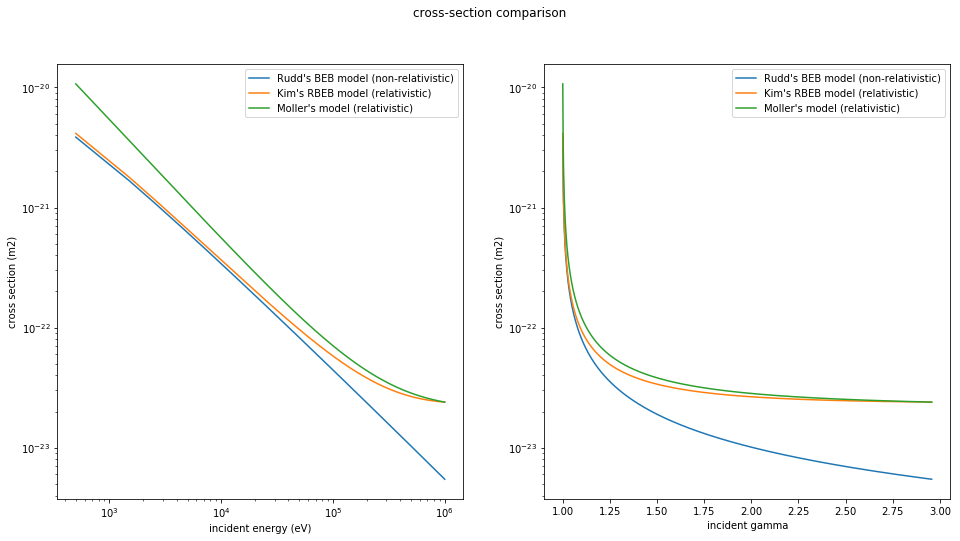

In [2]:
Tmax = 1.e6 # maximal incident energy (in eV)
n = 1000
T = np.linspace(.5 / n * Tmax, (1. - .5 / n) * Tmax, n) # incident energy in eV
gamma = e * T / (m_e * c**2) + 1.
v_T = c * np.sqrt(1. - np.divide(1., gamma**2))

# Calculate cross section using old Rudd BEB model
sigma = h2crosssections.h2_ioniz_crosssection(v_T)

Xsect_fig_0, [ax1, ax2] = plt.subplots(1, 2, figsize=(16, 8))

plt.suptitle('cross-section comparison')

ax1.plot(T, sigma, label='Rudd\'s BEB model (non-relativistic)')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlabel('incident energy (eV)')
ax1.set_ylabel('cross section (m2)')
ax2.plot(gamma, sigma, label='Rudd\'s BEB model (non-relativistic)')
ax2.set_yscale('log')
ax2.set_xlabel('incident gamma')
ax2.set_ylabel('cross section (m2)')

# Load module with updated version
sys.path.insert(1, '/home/vagrant/jupyter/rswarp/rswarp/ionization')
import crosssections as Xsect
# Calculate cross section using Kim RBEB model
h2 = Xsect.H2IonizationEvent()
sigma = h2.getCrossSection(v_T)

ax1.plot(T, sigma, label='Kim\'s RBEB model (relativistic)')
ax2.plot(gamma, sigma, label='Kim\'s RBEB model (relativistic)')

# Calculate cross section using Moller model
moller = Xsect.IonizationEvent()
moller.setEps_min(1.2)
sigma = moller.getCrossSection(v_T)

ax1.plot(T, sigma, label='Moller\'s model (relativistic)')
ax2.plot(gamma, sigma, label='Moller\'s model (relativistic)')

ax1.legend(loc = 'upper right')
ax2.legend(loc = 'upper right')
plt.savefig('Xsect_analysis0.png')
plt.show()

Comments: old, non-relativistic (Rudd's BEB) and new, relativistic (Kim's RBEB) cross sections agree up to tens of keV, as they should. At high energies RBEB converges with Moller, as it should, but only after I dialed in the cutoff energy $\epsilon_{min} = 1.2$ eV.

## Plot energy spectrum and angular distribution

Call IonizationEvent.ejectedEnergy and generateAngle methods to check that the energy spectrum and angular distribution, respectively, of emitted electrons look OK. Unit tests will later be developed based on the code snippets below.

Spent 0.002 s generating ejected energies
max. particle energy:  4192.598669482127  eV


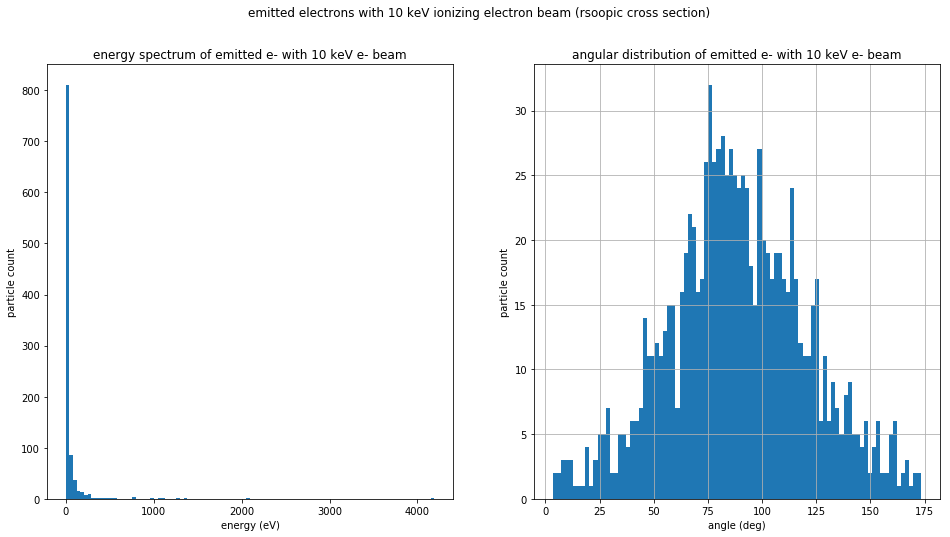

In [3]:
gamma = lambda v: math.sqrt(1./(1.-v*v/(c*c)))
#for i in range(10):
#    beta = 0.1949 + 0.00001 * i
#    v = beta * c
#    print i, beta, m_e * c * c * (gamma(v) - 1.) / e

#beta = 0.06247 # for 1 keV kinetic energy
beta = 0.19499 # for 10 keV kinetic energy
n = 1000
v = np.full((n), beta * c)

energy = h2.ejectedEnergy(v, n)
print 'max. particle energy: ', energy.max(), ' eV'

eps = np.full((n), m_e * c * c * (gamma(beta * c) - 1.) / e) # incident energy in eV
angle = h2.generateAngle(n, energy, eps)
angle *= 180. / math.pi

Xsect_fig_1, [ax1, ax2] = plt.subplots(1, 2, figsize=(16, 8))

plt.suptitle('emitted electrons with 10 keV ionizing electron beam (rsoopic cross section)')

ax1.hist(energy, 100)
ax1.set_title('energy spectrum of emitted e- with 10 keV e- beam')
ax1.set_xlabel('energy (eV)')
ax1.set_ylabel('particle count')
ax2.hist(angle, 90)
ax2.set_title('angular distribution of emitted e- with 10 keV e- beam')
ax2.set_xlabel('angle (deg)')
ax2.set_ylabel('particle count')
ax2.grid(True)\
        
plt.savefig('Xsect_analysis1.png')
plt.show()

### Moller cross section

Implementation of pure Moller cross section for comparison (this was done before Moller was added to IonizationTarget)

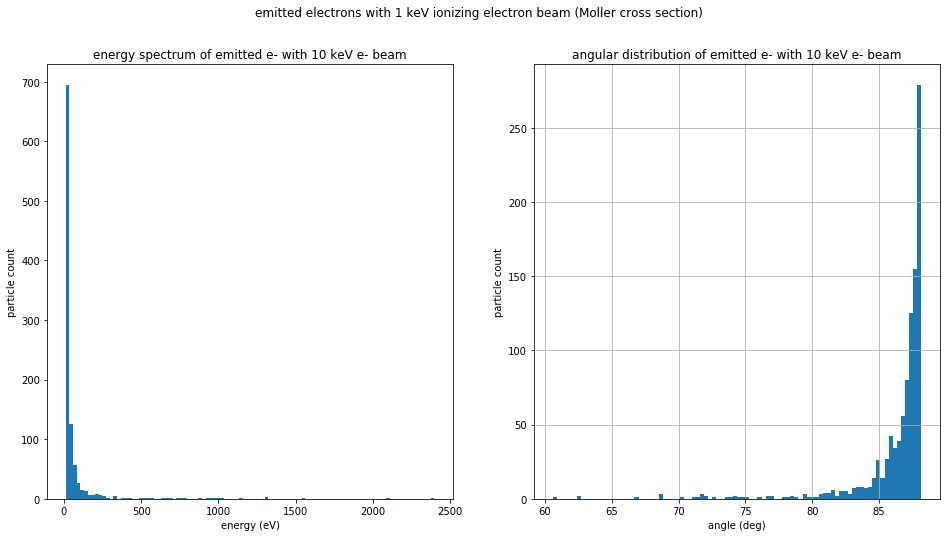

In [4]:
eps_min = 10. # value picked to give good agreement with rsoopic cross section results above
Ce = 2.0 * m_e * c * c / e

for i in range(n):
    Xrand = random.random()
    energy[i] = eps[i] * eps_min / (eps[i] - Xrand * (eps[i] - 2 * eps_min))
    costheta = energy[i] * (eps[i] + Ce)
    costheta /= eps[i] * (energy[i] + Ce)
    costheta = math.sqrt(costheta)
    angle[i] = 180. / math.pi * math.acos(costheta)

Xsect_fig_2, [ax1, ax2] = plt.subplots(1, 2, figsize=(16, 8))

plt.suptitle('emitted electrons with 1 keV ionizing electron beam (Moller cross section)')

ax1.hist(energy, 100)
ax1.set_title('energy spectrum of emitted e- with 10 keV e- beam')
ax1.set_xlabel('energy (eV)')
ax1.set_ylabel('particle count')
ax2.hist(angle, 90)
ax2.set_title('angular distribution of emitted e- with 10 keV e- beam')
ax2.set_xlabel('angle (deg)')
ax2.set_ylabel('particle count')
ax2.grid(True)
plt.savefig('Xsect_analysis2.png')
plt.show()

Comments: The emitted-electron energy spectrum is in good agreement with Moller at 1keV incident energy, but the angular distribution is much broader

### Angular spread isolated

Calculate angular distribution with both incident and emitted energy held fix, to see where the angular spread is coming from

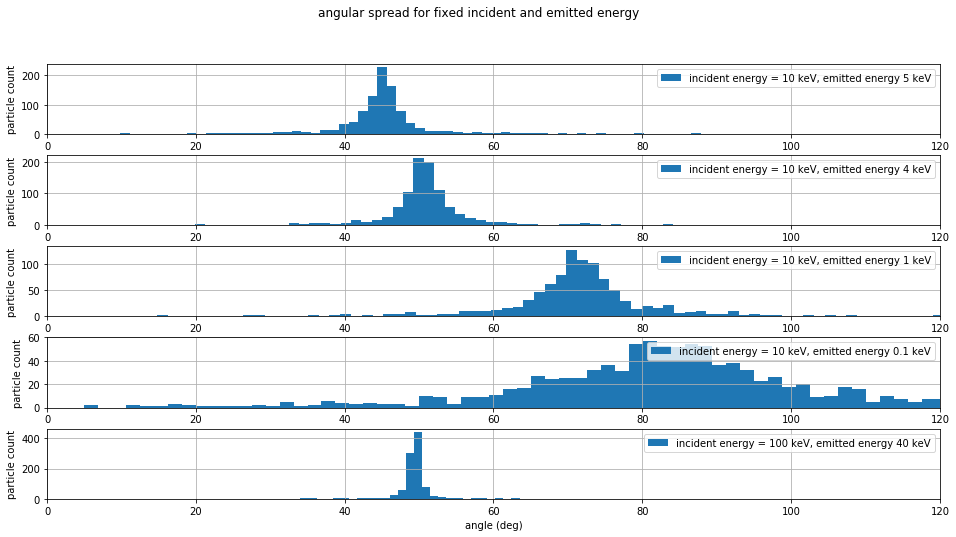

In [5]:
Xsect_fig_3, axes = plt.subplots(5, 1, figsize=(16, 8))
plt.suptitle('angular spread for fixed incident and emitted energy')

angle = 180. / math.pi * h2.generateAngle(n, 0.5 * eps, eps)
axes[0].hist(angle, 90, label='incident energy = 10 keV, emitted energy 5 keV')
#axes[0].set_title('emitted energy = 50% of incident energy')
axes[0].set_xlabel('angle (deg)')
axes[0].set_ylabel('particle count')
axes[0].grid(True)
axes[0].set_xlim([0, 120])

angle = 180. / math.pi * h2.generateAngle(n, 0.4 * eps, eps)
axes[1].hist(angle, 90, label='incident energy = 10 keV, emitted energy 4 keV')
#axes[1].set_title('emitted energy = 40% of incident energy')
axes[1].set_xlabel('angle (deg)')
axes[1].set_ylabel('particle count')
axes[1].grid(True)
axes[1].set_xlim([0, 120])

angle = 180. / math.pi * h2.generateAngle(n, 0.1 * eps, eps)
axes[2].hist(angle, 90, label='incident energy = 10 keV, emitted energy 1 keV')
#axes[2].set_title('emitted energy = 20% of incident energy')
axes[2].set_xlabel('angle (deg)')
axes[2].set_ylabel('particle count')
axes[2].grid(True)
axes[2].set_xlim([0, 120])

angle = 180. / math.pi * h2.generateAngle(n, 0.01 * eps, eps)
axes[3].hist(angle, 90, label='incident energy = 10 keV, emitted energy 0.1 keV')
#axes[3].set_title('emitted energy = 1% of incident energy')
axes[3].set_xlabel('angle (deg)')
axes[3].set_ylabel('particle count')
axes[3].grid(True)
axes[3].set_xlim([0, 120])

angle = 180. / math.pi * h2.generateAngle(n, 4. * eps, 10. * eps)
axes[4].hist(angle, 90, label='incident energy = 100 keV, emitted energy 40 keV')
#axes[4].set_title('emitted energy = 40% of incident energy of 1 MeV')
axes[4].set_xlabel('angle (deg)')
axes[4].set_ylabel('particle count')
axes[4].grid(True)
axes[4].set_xlim([0, 120])

# increase the vertical spacing between plots
plt.subplots_adjust(hspace=0.3)
for i in range(5):
    axes[i].legend(loc = 'upper right')
plt.savefig('Xsect_analysis3.png')
plt.show()

Comments: The broad angular distribution for the full energy spectrum is caused by electrons emitted at the lowest energies. The more energetic emitted electrons have a spread of about $\pm 5^{\circ}$ at 10 keV incident energy, which narrows further at 100 keV incident energy (bottom plot), as it should. The angular distribution thus seems reasonable after all.

# Tests of cross-section models for ion-impact ionization of $H_2$

/home/vagrant/jupyter/rswarp/rswarp/ionization/crosssections.py:96: RuntimeWarning: invalid value encountered in log
  np.log(eps_min_joule / (eps - eps_min_joule))


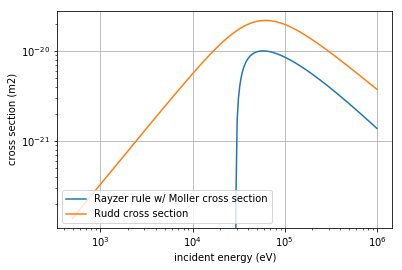

In [6]:
gamma = e * T / (m_p * c**2) + 1. # gamma values for incident protons
v_T = c * np.sqrt(1. - np.divide(1., gamma**2))

# Calculate cross section using Rayzer rule
p_on_h2 = Xsect.IonIonizationEvent()
sigma = p_on_h2.getCrossSection(v_T)
plt.loglog(T, sigma, label='Rayzer rule w/ Moller cross section')

# Calculate cross section using Rudd model
p_on_h2 = Xsect.RuddIonIonizationEvent()
sigma = p_on_h2.getCrossSection(v_T)
plt.loglog(T, sigma, label='Rudd cross section')

plt.xlabel('incident energy (eV)')
plt.ylabel('cross section (m2)')
plt.legend(loc = 'lower left')
plt.grid(True)
plt.show()

The simple (Rayzer rule w/ Moller) and sophisticated (Rudd) ion-impact ionization cross sections agree to within a factor of two at energies above the maximum. The Rayzer-rule cross section underestimates the Rudd one (and therefore supposedly the true cross section) at energies below the maximum, as expected.